In [1]:
import os, glob, random
from medpy.metric import binary
import pandas as pd
import SimpleITK as sitk
import numpy as np

def get_image_path_by_id(patient_id, image_dir):
    
    file_name = [os.path.relpath(os.path.join(image_dir, x)) \
                    for x in os.listdir(image_dir) \
                    if os.path.isfile(os.path.join(image_dir, x)) and patient_id in x]
    if len(file_name)>0:
        return file_name[0]
    else:
        return ''

In [7]:

df_init = pd.DataFrame()

manual_seg_dir =  'nnUNet_raw_data/label_in_nii_train526_kito/'
auto_seg_dir = 'nnUNet_raw_data/label_in_nii_train526_kito/'
csv_write_path= '../csv_results/nnunet_dsc.csv'

vox_spacing = [5.0,1.0,1.0]     

for idx, d in sorted(enumerate(os.listdir(manual_seg_dir))):
    if '.nii.gz' in d :
        print(idx, d,'processing')
        indices = [i for i, c in enumerate(d) if c == '_']
        pid = d[:indices[1]]
        auto_seg_path = get_image_path_by_id(pid, auto_seg_dir)
        manual_seg_path = get_image_path_by_id(pid, manual_seg_dir)

        if os.path.exists(auto_seg_path) and os.path.exists(manual_seg_path) :
            manual_seg_sitk = sitk.ReadImage(manual_seg_path)
            mskCube  = sitk.GetArrayFromImage(manual_seg_sitk)
            auto_seg_sitk = sitk.ReadImage(auto_seg_path)
            prdCube = sitk.GetArrayFromImage(auto_seg_sitk)

            mskCube_right, mskCube_left = mskCube.copy(), mskCube.copy()
            prdCube_right, prdCube_left = prdCube.copy(), prdCube.copy()
            
            mskCube_right[mskCube == 2] = 0  # get right kidney  (class 1) 
            prdCube_right[prdCube == 2] = 0  # get right kidney  (class 1) 
            mskCube_left[mskCube == 1] = 0  #  get left kidney (class 2)
            prdCube_left[prdCube == 1] = 0  # get left kidney  (class 1)  

            dsc_global = binary.dc(prdCube,mskCube)
            dsc_right = binary.dc(prdCube_right ,mskCube_right )
            dsc_left = binary.dc(prdCube_left,mskCube_left)
            
            jc_global = binary.jc(prdCube,mskCube)
            jc_right = binary.jc(prdCube_right ,mskCube_right )
            jc_left = binary.jc(prdCube_left,mskCube_left)            
            
            
            
            assd_global = binary.assd(prdCube,mskCube,vox_spacing, 1)
            assd_right = binary.assd(prdCube_right,mskCube_right,vox_spacing, 1)
            assd_left = binary.assd(prdCube_left,mskCube_left,vox_spacing, 1)

            df = pd.DataFrame({'CT_id': pid,  
                               'dsc_global':round(dsc_global,5),
                               'dsc_right':round(dsc_right,5),    'dsc_left':round(dsc_left,5),
                               'jc_global':round(jc_global,5),                               
                               'jc_right':round(jc_right,5),    'jc_left':round(jc_left,5),
                               'assd_global':round(assd_global,5),                               
                               'assd_right':round(assd_right,5),    'assd_left':round(assd_left,5),      
                              },index=[0])
            df_init = df_init.append(df)
            df_init.to_csv(csv_write_path )
            print(idx,'th pid:',pid,'dsc_global',round(dsc_global,5),'done \n\n\n')


0 Colon_001_kidney_2class_label_seg_kito.nii.gz processing
0 th pid: Colon_001 dsc_global 1.0 done 





In [8]:
print(df_init.shape)
df_init.head()

(1, 10)


,CT_id,dsc_global,dsc_right,dsc_left,jc_global,jc_right,jc_left,assd_global,assd_right,assd_left
0,Colon_001,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0


CSV shape (1,)
dsc_global mean value:  1.0
dsc_global std:  0.0


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.5 , 0.54, 0.58, 0.62, 0.66, 0.7 , 0.74, 0.78, 0.82, 0.86, 0.9 ,
        0.94, 0.98, 1.02, 1.06, 1.1 , 1.14, 1.18, 1.22, 1.26, 1.3 , 1.34,
        1.38, 1.42, 1.46, 1.5 ]),
 <BarContainer object of 25 artists>)

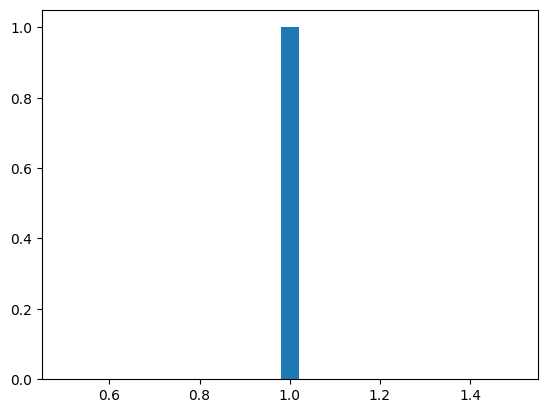

In [20]:
import matplotlib.pyplot as plt

col_str = 'dsc_global'
print('CSV shape',df_init[col_str].shape)
print(col_str, 'mean value: ',  np.mean(df_init[col_str]))
print(col_str,  'std: ',  np.std(df_init[col_str]))


plt.hist( df_init[col_str],bins = 25)

# plt.imshow